In [2]:
from sionna.channel import AWGN
from sionna.utils import BinarySource, ebnodb2no, log10, expand_to_rank, insert_dims
from sionna.mapping import Mapper, Demapper, Constellation
from sionna.utils import sim_ber
import sionna as sn

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv1D, Activation

In [ ]:
import utils
from utils.my_utils import  load_weights, bit2onehot, Normalize
import sys
sys.path.append('..')
from config import WEIGHTS_PATH

In [ ]:
#Initialized Parameters
n = 6000
num_bits_per_symbol = 4
M = 2**num_bits_per_symbol
coderate = 1.0
n_channel = 1
num_symbols_per_codeword = n//num_bits_per_symbol
weights_path = WEIGHTS_PATH

### AE-CNN

In [ ]:
class E2E_AE_CNN(Model):
    def __init__(self, training):
        super().__init__()
        self._training = training
        self._binary_source = BinarySource()

        # Transmitter
        self.conv1 = Conv1D(32, kernel_size=3, strides=1, padding='same')
        self.conv2 = Conv1D(16, kernel_size=3, strides=1, padding='same')
        self.dense_tx = Dense(2*n_channel)  # Outputs real and imaginary parts

        # Channel
        self._channel = AWGN()

        # Receiver
        self.conv3 = Conv1D(16, kernel_size=3, strides=1, padding='same')
        self.conv4 = Conv1D(32, kernel_size=3, strides=1, padding='same')
        self.dense_rx = Dense(2**num_bits_per_symbol, activation= 'softmax')

        if self._training:
            self._ce = tf.keras.losses.CategoricalCrossentropy()

    @tf.function()
    def call(self, batch_size, ebno_db):
        batch_size = tf.cast(batch_size, dtype=tf.int32)
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol = num_bits_per_symbol, coderate=1.0)


        b = self._binary_source([batch_size, n])
        _,indices,s_initial = bit2onehot(b,num_bits_per_symbol, batch_size,num_symbols_per_codeword)

        # Transmitter
        x = self.conv1(s_initial)
        x = Activation('relu')(x)

        x = self.conv2(x)
        x = Activation('relu')(x)


        x = self.dense_tx(x)
        x_real = x[:,:,:n_channel]
        x_img  = x[:,:,n_channel:]
        x = tf.cast(tf.complex(x_real, x_img), dtype=tf.complex64)
        x = Normalize(x)  # Normalization for power constraint

        # Channel
        y = self._channel([x, no])
        y = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=-1)

        # Receiver
        y = self.conv3(y)
        y = Activation('relu')(y)

        y = self.conv4(y)
        y = Activation('relu')(y)

        prob = self.dense_rx(y)


        if self._training:
            loss = self._ce(s_initial, prob)
            return loss
        else:
            s_hat = tf.argmax(prob, axis = -1)
            return indices,s_hat

### Training Effect of Eb/No on Performance: Symbol-wise AE-based E2E

In [10]:
ebno_dbs_eval = np.linspace(0, 20, 20)

In [11]:
SER_CNN ={}

In [12]:
num_bits_per_symbol = 4
num_symbols_per_codeword = n//num_bits_per_symbol

In [15]:
SER_CNN['AECNN_16QAM_4'] = []
model_weights_AE_CNN_16QAM_4 = weights_path +  f'/weights of AE_CNN_16QAM_SER_4'
model_AE_CNN_16QAM_4 = E2E_AE_CNN(False)
load_weights(model_AE_CNN_16QAM_4, model_weights_AE_CNN_16QAM_4)
for ebno in ebno_dbs_eval:
  indices_16QAM_4,s_hat_16QAM_4 = model_AE_CNN_16QAM_4(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  indices_16QAM_4 = tf.cast(indices_16QAM_4, tf.int64)
  indices_16QAM_4 = tf.reshape(indices_16QAM_4,s_hat_16QAM_4.shape)
  ser_16QAM_4 = sn.utils.compute_ser(indices_16QAM_4,s_hat_16QAM_4)
  SER_CNN['AECNN_16QAM_4'].append(ser_16QAM_4.numpy())

In [16]:
SER_CNN['AECNN_16QAM_8'] = []
model_weights_AE_CNN_16QAM_8 = weights_path +  f'/weights of AE_CNN_16QAM_SER_8'
model_AE_CNN_16QAM_8 = E2E_AE_CNN(False)
load_weights(model_AE_CNN_16QAM_8, model_weights_AE_CNN_16QAM_8)
for ebno in ebno_dbs_eval:
  indices_16QAM_8,s_hat_16QAM_8 = model_AE_CNN_16QAM_8(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  indices_16QAM_8 = tf.cast(indices_16QAM_8, tf.int64)
  indices_16QAM_8 = tf.reshape(indices_16QAM_8,s_hat_16QAM_8.shape)
  ser_16QAM_8 = sn.utils.compute_ser(indices_16QAM_8,s_hat_16QAM_8)
  SER_CNN['AECNN_16QAM_8'].append(ser_16QAM_8.numpy())

In [17]:
SER_CNN['AECNN_16QAM_12'] = []
model_weights_AE_CNN_16QAM_12 = weights_path +  f'/weights of AE_CNN_16QAM_SER_12'
model_AE_CNN_16QAM_12 = E2E_AE_CNN(False)
load_weights(model_AE_CNN_16QAM_12, model_weights_AE_CNN_16QAM_12)
for ebno in ebno_dbs_eval:
  indices_16QAM_12,s_hat_16QAM_12 = model_AE_CNN_16QAM_12(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  indices_16QAM_12 = tf.cast(indices_16QAM_12, tf.int64)
  indices_16QAM_12 = tf.reshape(indices_16QAM_12,s_hat_16QAM_12.shape)
  ser_16QAM_12 = sn.utils.compute_ser(indices_16QAM_12,s_hat_16QAM_12)
  SER_CNN['AECNN_16QAM_12'].append(ser_16QAM_12.numpy())

In [18]:
num_bits_per_symbol = 6
num_symbols_per_codeword = n//num_bits_per_symbol

In [19]:
SER_CNN['AECNN_64QAM_4'] = []
model_weights_AE_CNN_64QAM_4 = weights_path +  f'/weights of AE_CNN_64QAM_SER_4'
model_AE_CNN_64QAM_4 = E2E_AE_CNN(False)
load_weights(model_AE_CNN_64QAM_4, model_weights_AE_CNN_64QAM_4)
for ebno in ebno_dbs_eval:
  indices_64QAM_4,s_hat_64QAM_4 = model_AE_CNN_64QAM_4(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  indices_64QAM_4 = tf.cast(indices_64QAM_4, tf.int64)
  indices_64QAM_4 = tf.reshape(indices_64QAM_4,s_hat_64QAM_4.shape)
  ser_64QAM_4 = sn.utils.compute_ser(indices_64QAM_4,s_hat_64QAM_4)
  SER_CNN['AECNN_64QAM_4'].append(ser_64QAM_4.numpy())

In [20]:
SER_CNN['AECNN_64QAM_8'] = []
model_weights_AE_CNN_64QAM_8 = weights_path +  f'/weights of AE_CNN_64QAM_SER_8'
model_AE_CNN_64QAM_8 = E2E_AE_CNN(False)
load_weights(model_AE_CNN_64QAM_8, model_weights_AE_CNN_64QAM_8)
for ebno in ebno_dbs_eval:
  indices_64QAM_8,s_hat_64QAM_8 = model_AE_CNN_64QAM_8(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  indices_64QAM_8 = tf.cast(indices_64QAM_8, tf.int64)
  indices_64QAM_8 = tf.reshape(indices_64QAM_8,s_hat_64QAM_8.shape)
  ser_64QAM_8 = sn.utils.compute_ser(indices_64QAM_8,s_hat_64QAM_8)
  SER_CNN['AECNN_64QAM_8'].append(ser_64QAM_8.numpy())

In [21]:
SER_CNN['AECNN_64QAM_12'] = []
model_weights_AE_CNN_64QAM_12 = weights_path +  f'/weights of AE_CNN_64QAM_SER_12'
model_AE_CNN_64QAM_12 = E2E_AE_CNN(False)
load_weights(model_AE_CNN_64QAM_12, model_weights_AE_CNN_64QAM_12)
for ebno in ebno_dbs_eval:
  indices_64QAM_12,s_hat_64QAM_12 = model_AE_CNN_64QAM_12(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  indices_64QAM_12 = tf.cast(indices_64QAM_12, tf.int64)
  indices_64QAM_12 = tf.reshape(indices_64QAM_12,s_hat_64QAM_12.shape)
  ser_64QAM_12 = sn.utils.compute_ser(indices_64QAM_12,s_hat_64QAM_12)
  SER_CNN['AECNN_64QAM_12'].append(ser_64QAM_12.numpy())

In [22]:
num_bits_per_symbol = 8
num_symbols_per_codeword = n//num_bits_per_symbol

In [23]:
SER_CNN['AECNN_256QAM_4'] = []
model_weights_AE_CNN_256QAM_4 = weights_path +  f'/weights of AE_CNN_256QAM_SER_4'
model_AE_CNN_256QAM_4 = E2E_AE_CNN(False)
load_weights(model_AE_CNN_256QAM_4, model_weights_AE_CNN_256QAM_4)
for ebno in ebno_dbs_eval:
  indices_256QAM_4,s_hat_256QAM_4 = model_AE_CNN_256QAM_4(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  indices_256QAM_4 = tf.cast(indices_256QAM_4, tf.int64)
  indices_256QAM_4 = tf.reshape(indices_256QAM_4,s_hat_256QAM_4.shape)
  ser_256QAM_4 = sn.utils.compute_ser(indices_256QAM_4,s_hat_256QAM_4)
  SER_CNN['AECNN_256QAM_4'].append(ser_256QAM_4.numpy())

In [24]:
SER_CNN['AECNN_256QAM_8'] = []
model_weights_AE_CNN_256QAM_8 = weights_path +  f'/weights of AE_CNN_256QAM_SER_8'
model_AE_CNN_256QAM_8 = E2E_AE_CNN(False)
load_weights(model_AE_CNN_256QAM_8, model_weights_AE_CNN_256QAM_8)
for ebno in ebno_dbs_eval:
  indices_256QAM_8,s_hat_256QAM_8 = model_AE_CNN_256QAM_8(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  indices_256QAM_8 = tf.cast(indices_256QAM_8, tf.int64)
  indices_256QAM_8 = tf.reshape(indices_256QAM_8,s_hat_256QAM_8.shape)
  ser_256QAM_8 = sn.utils.compute_ser(indices_256QAM_8,s_hat_256QAM_8)
  SER_CNN['AECNN_256QAM_8'].append(ser_256QAM_8.numpy())

In [25]:
SER_CNN['AECNN_256QAM_12'] = []
model_weights_AE_CNN_256QAM_12 = weights_path +  f'/weights of AE_CNN_256QAM_SER_12'
model_AE_CNN_256QAM_12 = E2E_AE_CNN(False)
load_weights(model_AE_CNN_256QAM_12, model_weights_AE_CNN_256QAM_12)
for ebno in ebno_dbs_eval:
  indices_256QAM_12,s_hat_256QAM_12 = model_AE_CNN_256QAM_12(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  indices_256QAM_12 = tf.cast(indices_256QAM_12, tf.int64)
  indices_256QAM_12 = tf.reshape(indices_256QAM_12,s_hat_256QAM_12.shape)
  ser_256QAM_12 = sn.utils.compute_ser(indices_256QAM_12,s_hat_256QAM_12)
  SER_CNN['AECNN_256QAM_12'].append(ser_256QAM_12.numpy())

### Plot out

In [ ]:
new_blue = '#36A2EB'     # Vibrant medium blue
new_green = '#2ECC71'    # Bright emerald green
new_orange = '#E67E22'   # Warm orange

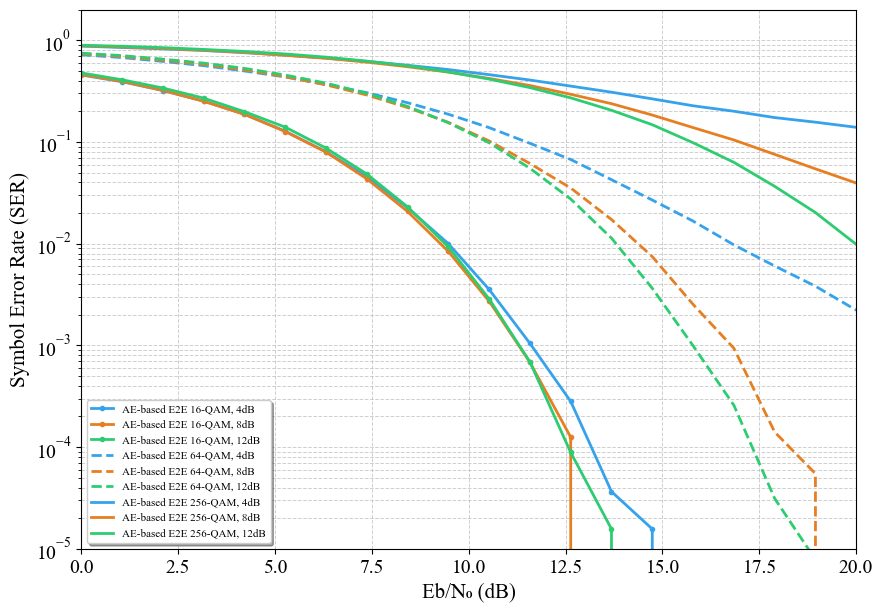

In [30]:
num_bits_per_symbol = 4
eb_no_db_range = np.linspace(0, 20, 20)

mpl.rcParams['font.family'] = 'serif'  # or 'sans-serif', 'monospace', etc.
mpl.rcParams['font.serif'] = ['Times New Roman']  # or any available font on your system
mpl.rcParams['font.size'] = 14  # Increase this for larger text

plt.figure(figsize=(10, 7))
plt.semilogy(eb_no_db_range, SER_CNN['AECNN_16QAM_4'], 'o-',color = new_blue, markersize=3, linewidth=2, label=f'AE-based E2E {2**num_bits_per_symbol}-QAM, 4dB')
plt.semilogy(eb_no_db_range, SER_CNN['AECNN_16QAM_8'], 'o-',color = new_orange, markersize=3, linewidth=2, label=f'AE-based E2E {2**num_bits_per_symbol}-QAM, 8dB')
plt.semilogy(eb_no_db_range, SER_CNN['AECNN_16QAM_12'], 'o-',color = new_green, markersize=3, linewidth=2, label=f'AE-based E2E {2**num_bits_per_symbol}-QAM, 12dB')
plt.semilogy(eb_no_db_range, SER_CNN['AECNN_64QAM_4'], '--',color = new_blue, markersize=3, linewidth=2, label=f'AE-based E2E {2**(num_bits_per_symbol+2)}-QAM, 4dB')
plt.semilogy(eb_no_db_range, SER_CNN['AECNN_64QAM_8'], '--',color = new_orange, markersize=3, linewidth=2, label=f'AE-based E2E {2**(num_bits_per_symbol+2)}-QAM, 8dB')
plt.semilogy(eb_no_db_range, SER_CNN['AECNN_64QAM_12'], '--',color= new_green, markersize=3, linewidth=2, label=f'AE-based E2E {2**(num_bits_per_symbol+2)}-QAM, 12dB')
plt.semilogy(eb_no_db_range, SER_CNN['AECNN_256QAM_4'], '-',color = new_blue, markersize=3, linewidth=2, label=f'AE-based E2E {2**(num_bits_per_symbol+4)}-QAM, 4dB')
plt.semilogy(eb_no_db_range, SER_CNN['AECNN_256QAM_8'], '-',color = new_orange,  markersize=3, linewidth=2, label=f'AE-based E2E {2**(num_bits_per_symbol+4)}-QAM, 8dB')
plt.semilogy(eb_no_db_range, SER_CNN['AECNN_256QAM_12'], '-',color = new_green, markersize=3, linewidth=2, label=f'AE-based E2E {2**(num_bits_per_symbol+4)}-QAM, 12dB')

plt.xlabel('Eb/N₀ (dB)', fontsize=15)
# plt.title(f'Symbol-wise AI-based Transceivers AE-CNN: Comparision SER under AWGN channel', fontsize= 10)
plt.legend(loc='lower left', fontsize=8, frameon=True, shadow=True, fancybox=True)
plt.xlabel('Eb/N₀ (dB)', fontsize=15)
plt.ylabel('Symbol Error Rate (SER)', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

plt.ylim(1e-5, 2)
plt.xlim(0,20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.show()